<a href="https://colab.research.google.com/github/shivanishah/satellite-image/blob/main/satellite_pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import csv
import cv2

In [4]:
!pip install Pillow
!pip install numpy
!pip install rasterio
!pip install matplotlib
!pip install scikit-learn
!pip install patchify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.3 MB/s eta 0:00:00


In [2]:
#if you have issue while installing tensorflow and segmentation models
!pip uninstall -y segmentation-models efficientnet image-classifiers keras tensorflow

In [3]:
!pip install tensorflow==2.9.1 keras==2.9.0
!pip install segmentation-models==1.0.1
!pip install efficientnet==1.0.0 image-classifiers==1.0.0

  Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.0 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511.7 MB)
Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.15.0 requires tensorflow<2.16,>=2.15.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.9.1 which is incompatible.
  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
  Using cached image_classifiers-1.0.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)


In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.merge import merge
from PIL import Image
from patchify import patchify
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import random

Segmentation Models: using `keras` framework.


In [7]:
# Define the input and output folder paths
base_input_folder = "drive/MyDrive/Colab Notebooks/satellite"
categories = ["Farm", "Dense Residential", "Forest"] #"Sparse Residential"
label_mapping = {
  'farm': 0,
  'dense residential': 1,
  'forest': 2
  #'sparse residential': 3
}
color_mapping = {
    0: [144/255, 238/255, 144/255],  # Light green for Farm
    1: [0/255, 0/255, 139/255],      # Dark blue for Dense Residential
    2: [0/255, 100/255, 0/255]      # Dark green for Forest
    #3: [135/255, 206/255, 250/255]   # Light blue for Sparse Residential
}

In [8]:
def apply_color_mapping(mask):
  # Create an empty RGB image
  colored_mask = np.zeros((*mask.shape, 3), dtype=np.float32)
  # Apply color mapping
  for label, color in color_mapping.items():
      colored_mask[mask == label] = color
  return colored_mask

In [9]:
minmaxscaler = MinMaxScaler()
patch_size = 128

In [10]:
# Initialize an empty list to store labels from masks
labels_dataset = []
# Initialize an empty list to store patches from images
image_dataset = []
# Initialize an empty list to store mask from images,labels
mask_dataset = []

# Iterate over each category to process image
for category in categories:
    # Construct the path to the pngImage folder within each category
    image_folder = os.path.join(base_input_folder, category, "pngImage")

    # Check if the folder exists before proceeding
    if not os.path.exists(image_folder):
        print(f"Warning: {image_folder} does not exist, skipping.")
        continue

    # List and process all PNG images in the folder
    images = sorted(os.listdir(image_folder))
    for i, image_name in enumerate(images):
        if image_name.endswith(".png"):  # Only process PNG images
            image_path = os.path.join(image_folder, image_name)

            # Read and process the image
            image = cv2.imread(image_path, 1)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #base 10 (decimal) colors

            # Check if the image dimensions are smaller than the patch size
            if image.shape[0] < patch_size or image.shape[1] < patch_size:
                print(f"Warning: Image {image_path} is smaller than patch size, skipping.")
                continue

            SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by patch size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by patch size

            # Crop the image to the nearest size divisible by patch size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)

            # Extract patches from the image
            #print(f"Now patchifying mask: {image_path}")
            patches_image = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=128 means no overlap

            # Iterate through patches and add them to the dataset
            for i in range(patches_image.shape[0]):
                for j in range(patches_image.shape[1]):
                    individual_patched_image = patches_image[i,j,:,:]
                    #print(individual_patched_image.shape)
                    #normalise dataset with minmaxscaler
                    individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
                    individual_patched_image = individual_patched_image[0]
                    #print(individual_patched_image.shape)
                    image_dataset.append(individual_patched_image)

                    # Create mask patch
                    mask_patch = np.full((patch_size, patch_size), label_mapping.get(category.lower(), 0))
                    mask_dataset.append(mask_patch)

                    # Add the label to the dataset based on the category
                    labels_dataset.append(category.lower())

In [66]:
print(f"Total number of image patches extracted: {len(image_dataset)}")
print(f"Total number of mask paches extracted: {len(mask_dataset)}")
print(f"Total number of label paches extracted: {len(labels_dataset)}")

Total number of image patches extracted: 1200
Total number of mask paches extracted: 1200
Total number of label paches extracted: 1200


In [67]:
mask_dataset[500].shape

(128, 128)

In [68]:
image_dataset[500].shape

(128, 128, 3)

In [69]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
labels_dataset = np.array(labels_dataset)

In [70]:
image_dataset[500]

array([[[0.9535865 , 0.91025641, 0.81702128],
        [0.92405063, 0.87606838, 0.79574468],
        [0.88185654, 0.86324786, 0.78297872],
        ...,
        [0.00843882, 0.02136752, 0.01276596],
        [0.01265823, 0.0042735 , 0.01702128],
        [0.092827  , 0.0042735 , 0.05106383]],

       [[0.92827004, 0.92735043, 0.85106383],
        [0.92405063, 0.90598291, 0.80425532],
        [0.87341772, 0.89316239, 0.78723404],
        ...,
        [0.02109705, 0.02564103, 0.03404255],
        [0.05485232, 0.04273504, 0.05957447],
        [0.24894515, 0.15384615, 0.14468085]],

       [[0.89029536, 0.92307692, 0.7787234 ],
        [0.86919831, 0.85897436, 0.76595745],
        [0.86919831, 0.85897436, 0.74893617],
        ...,
        [0.02109705, 0.02564103, 0.02553191],
        [0.08860759, 0.05982906, 0.08085106],
        [0.32489451, 0.26068376, 0.23404255]],

       ...,

       [[0.75527426, 0.73931624, 0.73617021],
        [0.92405063, 0.93589744, 0.83829787],
        [0.89873418, 0

#Data Augmentation

In [71]:
from scipy import ndimage

In [72]:
def apply_augmentation(image, mask):
  # Apply random rotations
  if np.random.rand() < 0.5:
    angle = np.random.randint(4) * 90
    image = ndimage.rotate(image, angle, reshape=False)
    mask = ndimage.rotate(mask, angle, reshape=False)

  # Apply vertical flips
  if np.random.rand() < 0.5:
    image = np.flip(image, 0)
    mask = np.flip(mask, 0)

  # Apply horizontal flips
  if np.random.rand() < 0.5:
    image = np.flip(image, 1)
    mask = np.flip(mask, 1)

  # Apply zooming
  if np.random.rand() < 0.5:
    zoom_factor = np.random.uniform(0.8, 1.2)
    image = ndimage.zoom(image, (zoom_factor, zoom_factor, 1), order=1)
    mask = ndimage.zoom(mask, (zoom_factor, zoom_factor), order=0)

  # Apply brightness adjustment
  if np.random.rand() < 0.5:
    brightness_factor = np.random.uniform(0.7, 1.3)
    image = np.clip(image * brightness_factor, 0, 1).astype(np.float32)

  # Apply contrast adjustment
  if np.random.rand() < 0.5:
    contrast_factor = np.random.uniform(0.7, 1.3)
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    image = np.clip((image - mean) * contrast_factor + mean, 0, 1).astype(np.float32)

  # Resize the image and mask
  image = cv2.resize(image, (128, 128))  # Keeping the original size
  mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

  return image, mask

In [73]:
augmented_image_dataset = []
augmented_mask_dataset = []
augmented_labels_dataset = []

# Add original image
augmented_image_dataset.append(image_dataset[0])
augmented_mask_dataset.append(mask_dataset[0])
augmented_labels_dataset.append(labels_dataset[0])

# Add augmented image
aug_image, aug_mask = apply_augmentation(image_dataset[0], mask_dataset[0])
augmented_image_dataset.append(aug_image)
augmented_mask_dataset.append(aug_mask)
augmented_labels_dataset.append(labels_dataset[0])

In [ ]:
## testing purpose - start

In [74]:
image_dataset[0]


array([[[0.04519774, 0.04210526, 0.05617978],
        [0.0960452 , 0.08947368, 0.11797753],
        [0.06214689, 0.05789474, 0.08426966],
        ...,
        [0.44632768, 0.42631579, 0.43258427],
        [0.48587571, 0.45263158, 0.46067416],
        [0.47457627, 0.44736842, 0.45505618]],

       [[0.02824859, 0.02631579, 0.03932584],
        [0.05649718, 0.05263158, 0.06179775],
        [0.04519774, 0.04210526, 0.05617978],
        ...,
        [0.28813559, 0.29473684, 0.29213483],
        [0.35028249, 0.33157895, 0.33707865],
        [0.44067797, 0.41578947, 0.42696629]],

       [[0.03389831, 0.03157895, 0.04494382],
        [0.04519774, 0.04210526, 0.0505618 ],
        [0.03954802, 0.03684211, 0.0505618 ],
        ...,
        [0.38418079, 0.42631579, 0.3988764 ],
        [0.26553672, 0.28421053, 0.2752809 ],
        [0.23163842, 0.23684211, 0.24157303]],

       ...,

       [[0.63276836, 0.57368421, 0.58988764],
        [0.61016949, 0.54210526, 0.56179775],
        [0.59887006, 0

In [75]:
mask_dataset[0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [76]:
augmented_mask_dataset[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [77]:
augmented_labels_dataset[1]

'farm'

In [78]:
labels_dataset[1]

'farm'

In [79]:
augmented_image_dataset = np.array(augmented_image_dataset)
augmented_image_dataset.shape

(2, 128, 128, 3)

In [80]:
augmented_mask_dataset = np.array(augmented_mask_dataset)
augmented_mask_dataset.shape

(2, 128, 128)

In [81]:
augmented_labels_dataset = np.array(augmented_labels_dataset)
augmented_labels_dataset.shape

(2,)

In [ ]:
## testing purpose end

In [82]:
augmented_image_dataset = []
augmented_mask_dataset = []
augmented_labels_dataset = []

for image, mask, label in zip(image_dataset, mask_dataset, labels_dataset):
  # Add original image
  augmented_image_dataset.append(image)
  augmented_mask_dataset.append(mask)
  augmented_labels_dataset.append(label)

  # Add augmented image
  aug_image, aug_mask = apply_augmentation(image, mask)
  augmented_image_dataset.append(aug_image)
  augmented_mask_dataset.append(aug_mask)
  augmented_labels_dataset.append(label)

# Convert to numpy arrays
augmented_image_dataset = np.array(augmented_image_dataset)
augmented_mask_dataset = np.array(augmented_mask_dataset)
augmented_labels_dataset = np.array(augmented_labels_dataset)

# Print the new sizes
print(f"Augmented image dataset shape: {augmented_image_dataset.shape}")
print(f"Augmented mask dataset shape: {augmented_mask_dataset.shape}")
print(f"Augmented labels dataset shape: {augmented_labels_dataset.shape}")

Augmented image dataset shape: (2400, 128, 128, 3)
Augmented mask dataset shape: (2400, 128, 128)
Augmented labels dataset shape: (2400,)


In [83]:
augmented_mask_dataset = np.expand_dims(augmented_mask_dataset, axis=3)
augmented_mask_dataset.shape

(2400, 128, 128, 1)

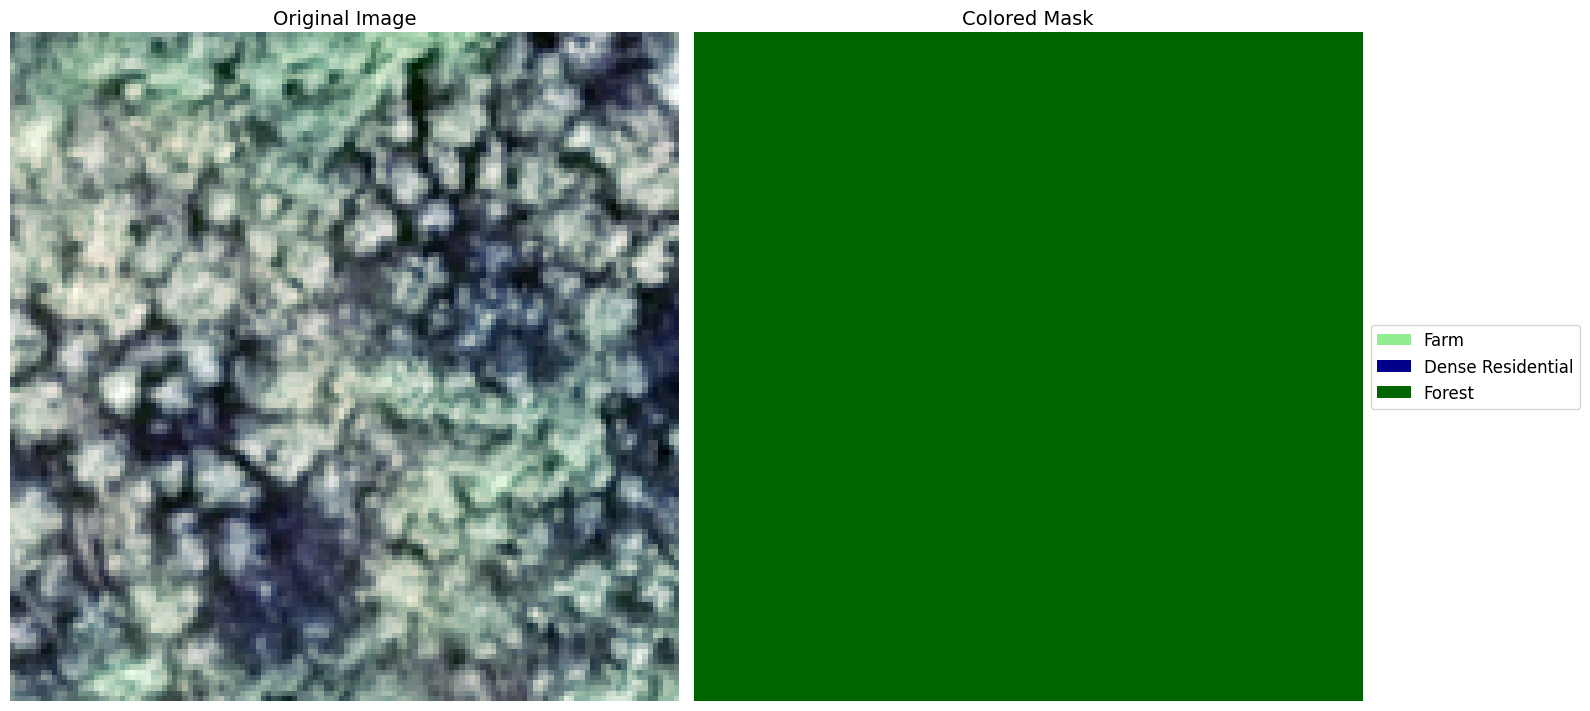

Category: Forest


In [85]:
# Select a random image and its corresponding mask
random_image_id = random.randint(0, len(augmented_image_dataset) - 1)
random_image = augmented_image_dataset[random_image_id]
random_mask = augmented_mask_dataset[random_image_id]

# Apply color mapping to the mask
colored_mask = apply_color_mapping(random_mask)
# Squeeze the colored mask to remove the extra dimension
colored_mask = np.squeeze(colored_mask)

# Create the plot
plt.figure(figsize=(16, 8))

# Display original image
plt.subplot(121)
plt.title("Original Image", fontsize=14)
plt.imshow(random_image)
plt.axis('off')

# Display colored mask
plt.subplot(122)
plt.title("Colored Mask", fontsize=14)
plt.imshow(colored_mask)
plt.axis('off')

# Create a custom legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color_mapping[label_mapping[cat.lower()]], label=cat) for cat in categories]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

# Print the category of the selected image
print(f"Category: {categories[label_mapping[augmented_labels_dataset[random_image_id]]]}")

#Continue checking original dataset

In [87]:
mask_dataset[1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [88]:
mask_dataset = np.expand_dims(mask_dataset, axis=3)
mask_dataset.shape

(1200, 128, 128, 1)

In [89]:
mask_dataset[1]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

In [90]:
print("Image dataset shape:", image_dataset.shape)
print("Mask dataset shape:", mask_dataset.shape)
print("Labels dataset shape:", labels_dataset.shape)

# Print unique values in mask_dataset to confirm correct labeling
print("Unique values in mask_dataset:", np.unique(mask_dataset))

Image dataset shape: (1200, 128, 128, 3)
Mask dataset shape: (1200, 128, 128, 1)
Labels dataset shape: (1200,)
Unique values in mask_dataset: [0 1 2]


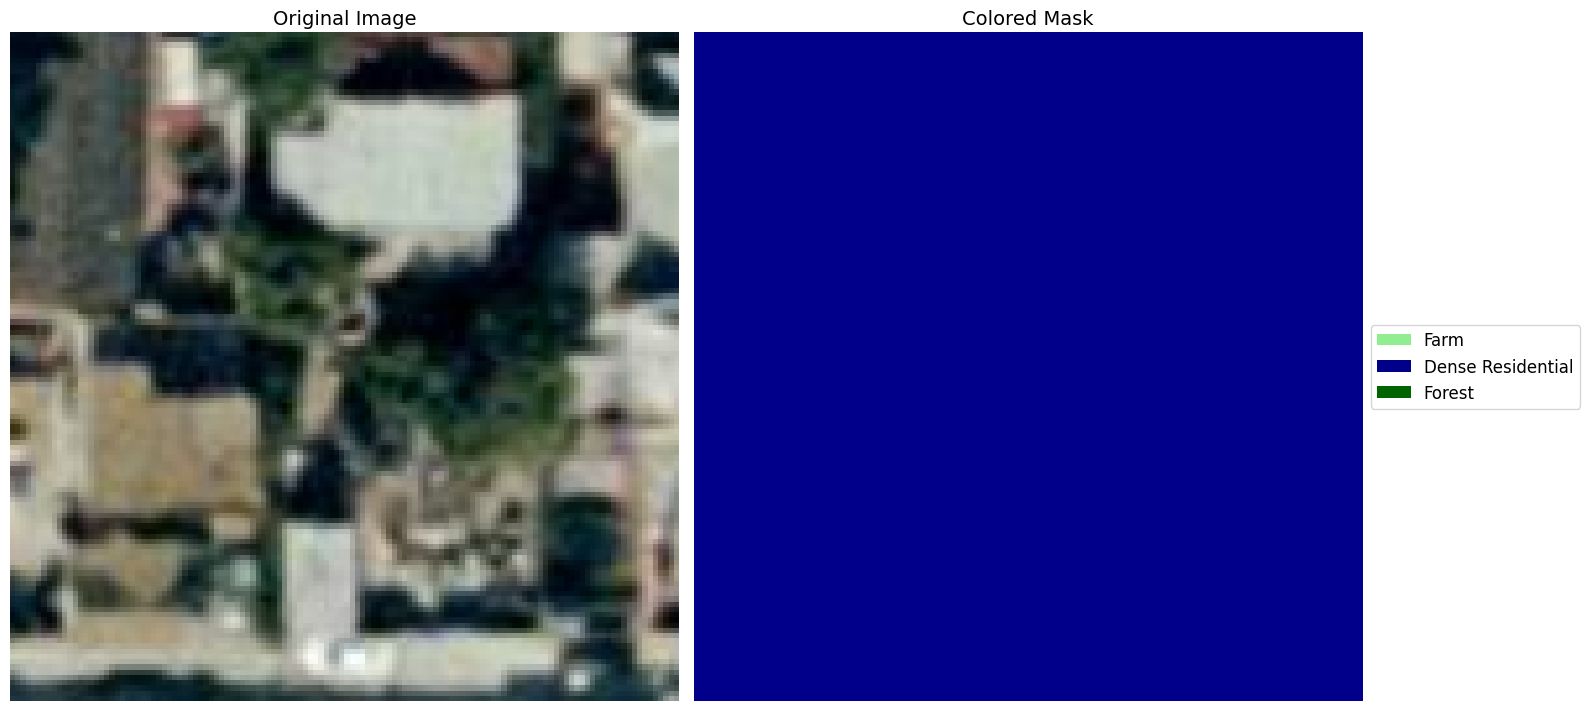

Category: Dense Residential


In [91]:
# Select a random image and its corresponding mask
random_image_id = random.randint(0, len(image_dataset) - 1)
random_image = image_dataset[random_image_id]
random_mask = mask_dataset[random_image_id]

# Apply color mapping to the mask
colored_mask = apply_color_mapping(random_mask)
# Squeeze the colored mask to remove the extra dimension
colored_mask = np.squeeze(colored_mask)

# Create the plot
plt.figure(figsize=(16, 8))

# Display original image
plt.subplot(121)
plt.title("Original Image", fontsize=14)
plt.imshow(random_image)
plt.axis('off')

# Display colored mask
plt.subplot(122)
plt.title("Colored Mask", fontsize=14)
plt.imshow(colored_mask)
plt.axis('off')

# Create a custom legend
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color_mapping[label_mapping[cat.lower()]],
                               label=cat)
                 for cat in categories]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.tight_layout()
plt.show()

# Print the category of the selected image
print(f"Category: {categories[label_mapping[labels_dataset[random_image_id]]]}")

#EDA

In [ ]:
from collections import Counter

Class distribution:
farm: 400
dense residential: 400
forest: 400
sparse residential: 394


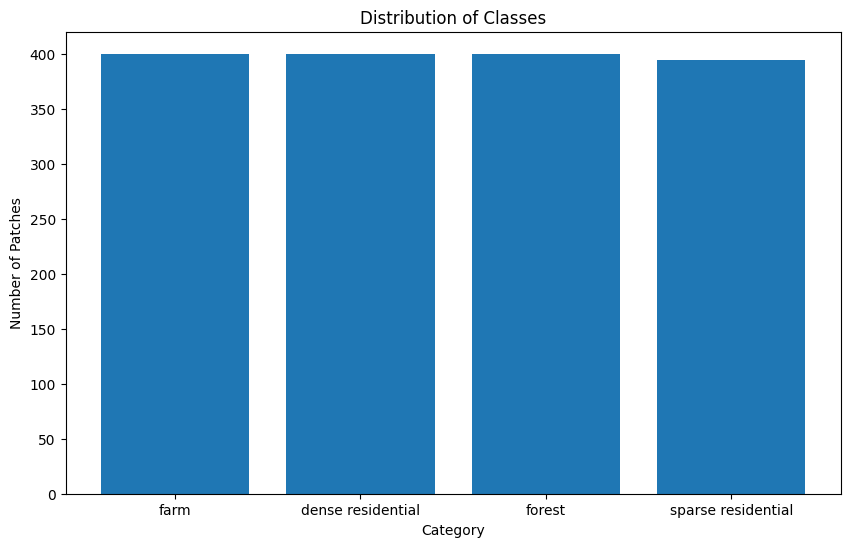

In [ ]:
#Count the occurrences of each class:
class_distribution = Counter(labels_dataset)

print("Class distribution:")
for category, count in class_distribution.items():
  print(f"{category}: {count}")

# Visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Distribution of Classes")
plt.xlabel("Category")
plt.ylabel("Number of Patches")
plt.show()

In [ ]:
#Calculate the percentage of each class:
total_patches = len(labels_dataset)
for category, count in class_distribution.items():
  percentage = (count / total_patches) * 100
  print(f"{category}: {percentage:.2f}%")

farm: 25.09%
dense residential: 25.09%
forest: 25.09%
sparse residential: 24.72%


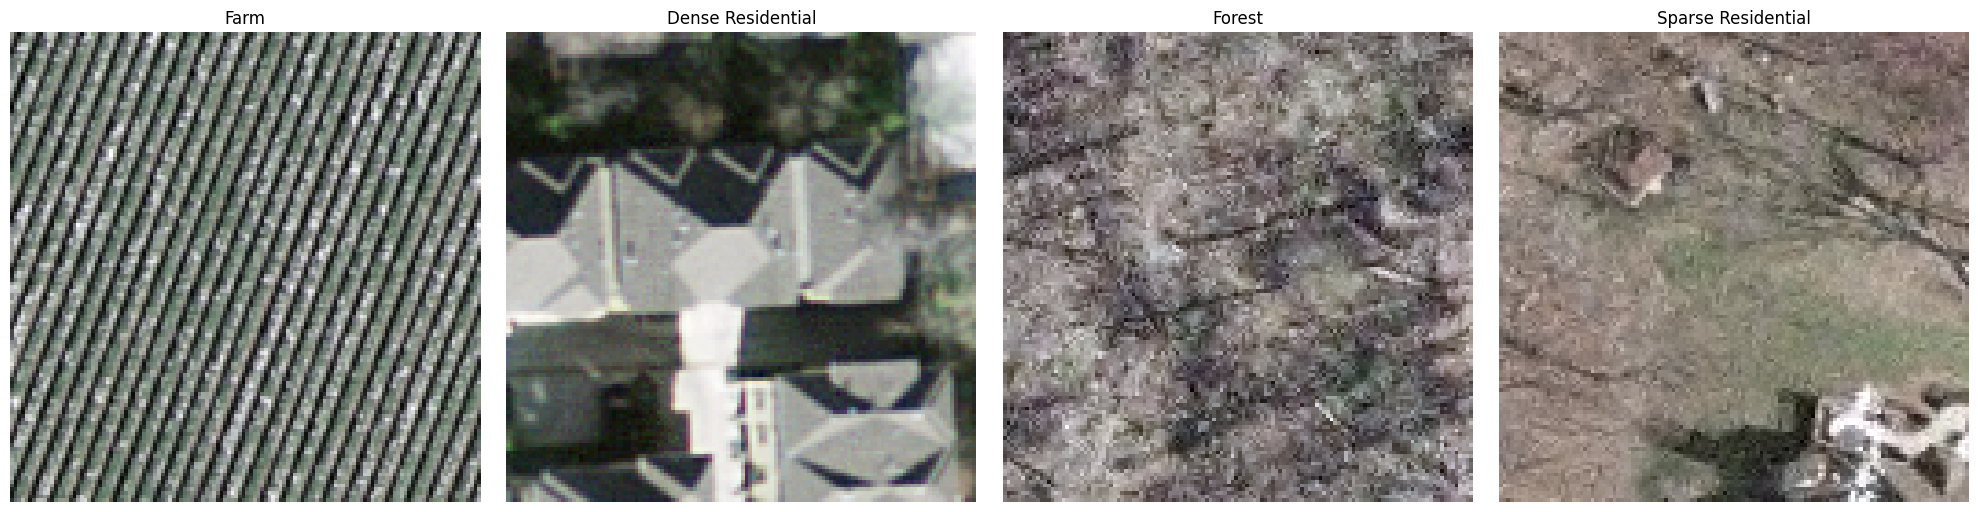

In [ ]:
#Display sample images from each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  random_index = np.random.choice(category_indices)
  plt.subplot(1, 4, i+1)
  plt.imshow(image_dataset[random_index])
  plt.title(category)
  plt.axis('off')
plt.tight_layout()
plt.show()

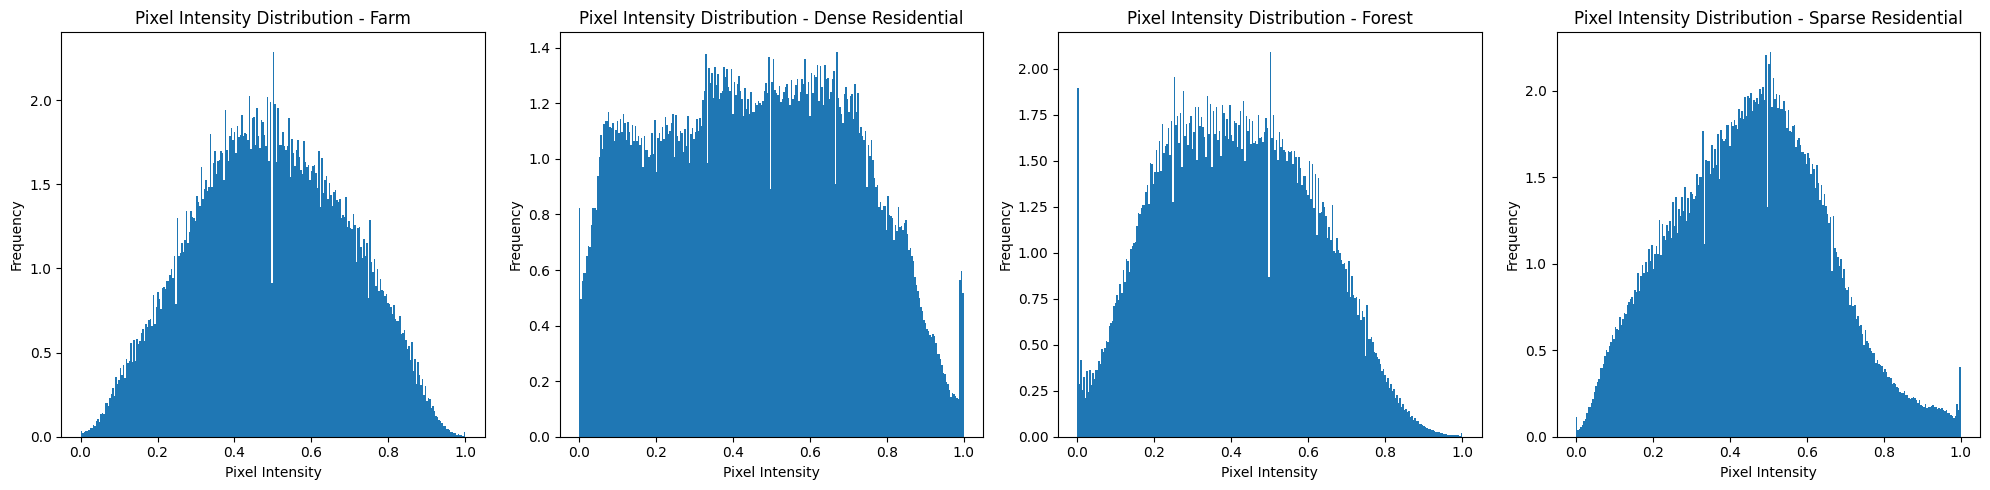

In [ ]:
#Analyze pixel intensity distribution for each category:
plt.figure(figsize=(20, 5))
for i, category in enumerate(categories):
  category_indices = np.where(labels_dataset == category.lower())[0]
  category_images = image_dataset[category_indices]
  plt.subplot(1, 4, i+1)
  plt.hist(category_images.ravel(), bins=256, range=(0, 1), density=True)
  plt.title(f"Pixel Intensity Distribution - {category}")
  plt.xlabel("Pixel Intensity")
  plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

1. Farm: The distribution is roughly symmetric, peaking around the middle intensity values. This suggests a balanced range of pixel intensities, indicating a mix of light and dark areas.
2. Dense Residential: The distribution is more uniform, with a slight peak towards higher intensities. This could indicate a prevalence of brighter areas, possibly due to reflective surfaces or artificial lighting.
3. Forest: The distribution is similar to the Farm category, with a peak around the middle. This suggests a mix of shadows and sunlight typical of forested areas.
4. Sparse Residential: The distribution is also symmetric, with a peak around the middle. This indicates a mix of open spaces and structures, leading to varied pixel intensities.

# Training and testing Dataset

In [92]:
image_dataset = augmented_image_dataset
mask_dataset = augmented_mask_dataset
labels_dataset = augmented_labels_dataset
mask_dataset.shape

(2400, 128, 128, 1)

In [93]:
total_classes = len(np.unique(mask_dataset))
total_classes

3

In [94]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [95]:
mask_dataset[90]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])

In [96]:
labels_categorical_dataset = to_categorical(mask_dataset, num_classes=total_classes)

In [97]:
labels_categorical_dataset[90]

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       ...,

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]], dtype=float32)

In [98]:
labels_categorical_dataset

array([[[[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        ...,

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]],

        [[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         ...,
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]],


       [[[1., 0., 0.],
         [1., 0., 0.],
         [1., 

In [99]:
image_dataset.shape

(2400, 128, 128, 3)

In [101]:
master_trianing_dataset = image_dataset

In [102]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.30, random_state=100)

In [103]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1680, 128, 128, 3)
(720, 128, 128, 3)
(1680, 128, 128, 3)
(720, 128, 128, 3)


In [104]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

128
128
3
3


# Deep Learning with Satellite Imagery Data

In [105]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [106]:
from keras import backend as K

In [107]:
#https://en.wikipedia.org/wiki/Jaccard_index
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [108]:
def multi_unet_model(n_classes=3, image_height=128, image_width=128, image_channels=3):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1) #drop 20% value
  c1 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(8, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(8, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [109]:
metrics = ["accuracy", jaccard_coef]

In [110]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [111]:
model = get_deep_learning_model()

In [112]:
model.get_config()

{'name': 'model',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 128, 128, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_1'},
   'name': 'input_1',
   'inbound_nodes': []},
  {'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'dtype': 'float32',
    'filters': 8,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'groups': 1,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'HeNormal', 'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None},
   'name': 'conv2d',
   'inbound_nodes': [[['input_1', 0, 0, {}]]]},
  {'class_name': 'Dropout',
   'config': {'name': 'd

#Generating Loss Function

*   dice loss > Focal Loss > Total Loss
*   Total Loss = (Dice loss + (1*Focal Loss))



In [113]:
import segmentation_models as sm

In [114]:
weights = [0.33,0.33,0.33] # 3 classes so equal weight 1/3

In [115]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [116]:
total_loss

#Model compilation

In [117]:
import tensorflow as tf

In [118]:
tf.keras.backend.clear_session()

In [119]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [120]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 8)  224         ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 8)  584         ['dropout[0][0]']            

#Visualize Model with Keras

In [123]:
!pip install pydot

In [121]:
from keras.utils.vis_utils import plot_model

In [124]:
plot_model(model, to_file="satellite_model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [125]:
import keras
from IPython.display import clear_output

%matplotlib inline

In [ ]:
class PlotLossEx(keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []

    self.losses = []
    self.val_losses = []

    self.jaccard_coef = []
    self.val_jaccard_coef = []

    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
    self.logs.append(logs)
    self.x.append(self.i)

    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.jaccard_coef.append(logs.get('jaccard_coef'))
    self.val_jaccard_coef.append(logs.get('val_jaccard_coef'))

    self.i += 1

    plt.figure(figsize=(14,8))
    f, (graph1, graph2) = plt.subplots(1,2, sharex=True)

    clear_output(wait=True)

    graph1.set_yscale('log')
    graph1.plot(self.x, self.losses, label="loss")
    graph1.plot(self.x, self.val_losses, label="val_loss")
    graph1.legend()

    graph2.set_yscale('log')
    graph2.plot(self.x, self.jaccard_coef, label="jaccard_coef")
    graph2.plot(self.x, self.val_jaccard_coef, label="val_jaccard_coef")
    graph2.legend()

    plt.show();

plot_loss = PlotLossEx()

In [126]:
!pip install wandb -qU

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.1 MB/s eta 0:00:00


In [127]:
!pip install --upgrade wandb

In [128]:
# Log in to your W&B account
import wandb
# Use wandb-core, temporary for wandb's new backend
wandb.require("core")
#from wandb.keras import WandbCallback
from wandb.integration.keras import WandbCallback

wandb: WARNING `wandb.require('core')` is redundant as it is now the default behavior.


In [129]:
wandb.init(project="satellite-imagery", entity="shah-shivani1993-university-of-south-australia")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [130]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [131]:
!wandb status

Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [132]:
wandb.log({'accuracy': jaccard_coef, 'loss': total_loss})
wandb.config.dropout = 0.2

(1920, 128, 128, 3)
(480, 128, 128, 3)
(1920, 128, 128, 3)
(480, 128, 128, 3)

In [134]:
model_history = model.fit(X_train, y_train,
                          batch_size=32, #give based on total X_train dataset so 1680/32 = 60 times loop
                          verbose=1,
                          epochs=70, #going to run 50 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          #callbacks=[plot_loss],
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)
#accuracy of train dataset

Epoch 1/70
53/53 [==============================] - ETA: 0s - loss: 0.9322 - accuracy: 0.3397 - jaccard_coef: 0.2001

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 399ms/step - loss: 0.9322 - accuracy: 0.3397 - jaccard_coef: 0.2001 - val_loss: 0.9321 - val_accuracy: 0.3413 - val_jaccard_coef: 0.2003
Epoch 2/70
53/53 [==============================] - ETA: 0s - loss: 0.9316 - accuracy: 0.3559 - jaccard_coef: 0.2010

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 402ms/step - loss: 0.9316 - accuracy: 0.3559 - jaccard_coef: 0.2010 - val_loss: 0.9306 - val_accuracy: 0.3839 - val_jaccard_coef: 0.2022
Epoch 3/70
53/53 [==============================] - ETA: 0s - loss: 0.9288 - accuracy: 0.3977 - jaccard_coef: 0.2060

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 394ms/step - loss: 0.9288 - accuracy: 0.3977 - jaccard_coef: 0.2060 - val_loss: 0.9195 - val_accuracy: 0.4576 - val_jaccard_coef: 0.2192
Epoch 4/70
53/53 [==============================] - ETA: 0s - loss: 0.9046 - accuracy: 0.4756 - jaccard_coef: 0.2622

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 391ms/step - loss: 0.9046 - accuracy: 0.4756 - jaccard_coef: 0.2622 - val_loss: 0.8927 - val_accuracy: 0.5353 - val_jaccard_coef: 0.2752
Epoch 5/70
53/53 [==============================] - ETA: 0s - loss: 0.8738 - accuracy: 0.5718 - jaccard_coef: 0.3352

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 395ms/step - loss: 0.8738 - accuracy: 0.5718 - jaccard_coef: 0.3352 - val_loss: 0.8611 - val_accuracy: 0.6380 - val_jaccard_coef: 0.3611
Epoch 6/70
53/53 [==============================] - 16s 308ms/step - loss: 0.8725 - accuracy: 0.5924 - jaccard_coef: 0.3386 - val_loss: 0.8625 - val_accuracy: 0.6454 - val_jaccard_coef: 0.3540
Epoch 7/70
53/53 [==============================] - ETA: 0s - loss: 0.8555 - accuracy: 0.6584 - jaccard_coef: 0.3773

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 395ms/step - loss: 0.8555 - accuracy: 0.6584 - jaccard_coef: 0.3773 - val_loss: 0.8487 - val_accuracy: 0.6711 - val_jaccard_coef: 0.3782
Epoch 8/70
53/53 [==============================] - ETA: 0s - loss: 0.8523 - accuracy: 0.6651 - jaccard_coef: 0.3834

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 386ms/step - loss: 0.8523 - accuracy: 0.6651 - jaccard_coef: 0.3834 - val_loss: 0.8435 - val_accuracy: 0.7003 - val_jaccard_coef: 0.4098
Epoch 9/70
53/53 [==============================] - ETA: 0s - loss: 0.8347 - accuracy: 0.7208 - jaccard_coef: 0.4201

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 396ms/step - loss: 0.8347 - accuracy: 0.7208 - jaccard_coef: 0.4201 - val_loss: 0.8220 - val_accuracy: 0.7327 - val_jaccard_coef: 0.4409
Epoch 10/70
53/53 [==============================] - ETA: 0s - loss: 0.8181 - accuracy: 0.7623 - jaccard_coef: 0.4552

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 390ms/step - loss: 0.8181 - accuracy: 0.7623 - jaccard_coef: 0.4552 - val_loss: 0.8155 - val_accuracy: 0.7792 - val_jaccard_coef: 0.4664
Epoch 11/70
53/53 [==============================] - ETA: 0s - loss: 0.8122 - accuracy: 0.7884 - jaccard_coef: 0.4732

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 382ms/step - loss: 0.8122 - accuracy: 0.7884 - jaccard_coef: 0.4732 - val_loss: 0.7981 - val_accuracy: 0.8243 - val_jaccard_coef: 0.5075
Epoch 12/70
53/53 [==============================] - ETA: 0s - loss: 0.8005 - accuracy: 0.8161 - jaccard_coef: 0.5078

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 397ms/step - loss: 0.8005 - accuracy: 0.8161 - jaccard_coef: 0.5078 - val_loss: 0.7883 - val_accuracy: 0.8506 - val_jaccard_coef: 0.5553
Epoch 13/70
53/53 [==============================] - 16s 306ms/step - loss: 0.7995 - accuracy: 0.8166 - jaccard_coef: 0.5187 - val_loss: 0.8263 - val_accuracy: 0.7408 - val_jaccard_coef: 0.4353
Epoch 14/70
53/53 [==============================] - ETA: 0s - loss: 0.7987 - accuracy: 0.8119 - jaccard_coef: 0.5188

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 391ms/step - loss: 0.7987 - accuracy: 0.8119 - jaccard_coef: 0.5188 - val_loss: 0.7859 - val_accuracy: 0.8351 - val_jaccard_coef: 0.5616
Epoch 15/70
53/53 [==============================] - ETA: 0s - loss: 0.7773 - accuracy: 0.8555 - jaccard_coef: 0.5871

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 383ms/step - loss: 0.7773 - accuracy: 0.8555 - jaccard_coef: 0.5871 - val_loss: 0.7567 - val_accuracy: 0.8966 - val_jaccard_coef: 0.6558
Epoch 16/70
53/53 [==============================] - 16s 305ms/step - loss: 0.7655 - accuracy: 0.8813 - jaccard_coef: 0.6361 - val_loss: 0.7615 - val_accuracy: 0.8875 - val_jaccard_coef: 0.6530
Epoch 17/70
53/53 [==============================] - ETA: 0s - loss: 0.7583 - accuracy: 0.8947 - jaccard_coef: 0.6668

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 382ms/step - loss: 0.7583 - accuracy: 0.8947 - jaccard_coef: 0.6668 - val_loss: 0.7524 - val_accuracy: 0.9004 - val_jaccard_coef: 0.6724
Epoch 18/70
53/53 [==============================] - ETA: 0s - loss: 0.7495 - accuracy: 0.9033 - jaccard_coef: 0.6940

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 384ms/step - loss: 0.7495 - accuracy: 0.9033 - jaccard_coef: 0.6940 - val_loss: 0.7402 - val_accuracy: 0.9199 - val_jaccard_coef: 0.7136
Epoch 19/70
53/53 [==============================] - ETA: 0s - loss: 0.7419 - accuracy: 0.9176 - jaccard_coef: 0.7242

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 374ms/step - loss: 0.7419 - accuracy: 0.9176 - jaccard_coef: 0.7242 - val_loss: 0.7380 - val_accuracy: 0.9185 - val_jaccard_coef: 0.7436
Epoch 20/70
53/53 [==============================] - 16s 309ms/step - loss: 0.7473 - accuracy: 0.9052 - jaccard_coef: 0.7123 - val_loss: 0.7414 - val_accuracy: 0.9074 - val_jaccard_coef: 0.7211
Epoch 21/70
53/53 [==============================] - ETA: 0s - loss: 0.7538 - accuracy: 0.8877 - jaccard_coef: 0.6837

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 378ms/step - loss: 0.7538 - accuracy: 0.8877 - jaccard_coef: 0.6837 - val_loss: 0.7325 - val_accuracy: 0.9287 - val_jaccard_coef: 0.7672
Epoch 22/70
53/53 [==============================] - ETA: 0s - loss: 0.7343 - accuracy: 0.9217 - jaccard_coef: 0.7583

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 392ms/step - loss: 0.7343 - accuracy: 0.9217 - jaccard_coef: 0.7583 - val_loss: 0.7236 - val_accuracy: 0.9443 - val_jaccard_coef: 0.7902
Epoch 23/70
53/53 [==============================] - 17s 312ms/step - loss: 0.7250 - accuracy: 0.9382 - jaccard_coef: 0.7914 - val_loss: 0.7270 - val_accuracy: 0.9412 - val_jaccard_coef: 0.7725
Epoch 24/70
53/53 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.9371 - jaccard_coef: 0.7955

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 375ms/step - loss: 0.7232 - accuracy: 0.9371 - jaccard_coef: 0.7955 - val_loss: 0.7162 - val_accuracy: 0.9452 - val_jaccard_coef: 0.8172
Epoch 25/70
53/53 [==============================] - ETA: 0s - loss: 0.7184 - accuracy: 0.9456 - jaccard_coef: 0.8155

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 397ms/step - loss: 0.7184 - accuracy: 0.9456 - jaccard_coef: 0.8155 - val_loss: 0.7139 - val_accuracy: 0.9548 - val_jaccard_coef: 0.8283
Epoch 26/70
53/53 [==============================] - 16s 304ms/step - loss: 0.7923 - accuracy: 0.8697 - jaccard_coef: 0.6976 - val_loss: 0.7421 - val_accuracy: 0.8933 - val_jaccard_coef: 0.7337
Epoch 27/70
53/53 [==============================] - 17s 315ms/step - loss: 0.7374 - accuracy: 0.9049 - jaccard_coef: 0.7615 - val_loss: 0.7306 - val_accuracy: 0.9167 - val_jaccard_coef: 0.7748
Epoch 28/70
53/53 [==============================] - 16s 305ms/step - loss: 0.7393 - accuracy: 0.9029 - jaccard_coef: 0.7636 - val_loss: 0.7551 - val_accuracy: 0.8850 - val_jaccard_coef: 0.7518
Epoch 29/70
53/53 [==============================] - 16s 305ms/step - loss: 0.7318 - accuracy: 0.9119 - jaccard_coef: 0.7953 - val_loss: 0.7186 - val_accuracy: 0.9323 - val_jaccard_coef: 0.8250
Epoch 30/70
53/53 [=======================

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 21s 394ms/step - loss: 0.7116 - accuracy: 0.9404 - jaccard_coef: 0.8552 - val_loss: 0.7044 - val_accuracy: 0.9491 - val_jaccard_coef: 0.8832
Epoch 31/70
53/53 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.9546 - jaccard_coef: 0.8922

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 386ms/step - loss: 0.7021 - accuracy: 0.9546 - jaccard_coef: 0.8922 - val_loss: 0.7017 - val_accuracy: 0.9534 - val_jaccard_coef: 0.8901
Epoch 32/70
53/53 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.9582 - jaccard_coef: 0.8983

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 383ms/step - loss: 0.7006 - accuracy: 0.9582 - jaccard_coef: 0.8983 - val_loss: 0.7006 - val_accuracy: 0.9539 - val_jaccard_coef: 0.8806
Epoch 33/70
53/53 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.9606 - jaccard_coef: 0.9069

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 385ms/step - loss: 0.6966 - accuracy: 0.9606 - jaccard_coef: 0.9069 - val_loss: 0.6948 - val_accuracy: 0.9660 - val_jaccard_coef: 0.9126
Epoch 34/70
53/53 [==============================] - 16s 305ms/step - loss: 0.6955 - accuracy: 0.9636 - jaccard_coef: 0.9134 - val_loss: 0.6949 - val_accuracy: 0.9643 - val_jaccard_coef: 0.9085
Epoch 35/70
53/53 [==============================] - ETA: 0s - loss: 0.6908 - accuracy: 0.9698 - jaccard_coef: 0.9287

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 386ms/step - loss: 0.6908 - accuracy: 0.9698 - jaccard_coef: 0.9287 - val_loss: 0.6936 - val_accuracy: 0.9682 - val_jaccard_coef: 0.9179
Epoch 36/70
53/53 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.9799 - jaccard_coef: 0.9488

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 383ms/step - loss: 0.6849 - accuracy: 0.9799 - jaccard_coef: 0.9488 - val_loss: 0.6897 - val_accuracy: 0.9742 - val_jaccard_coef: 0.9385
Epoch 37/70
53/53 [==============================] - 16s 308ms/step - loss: 0.6855 - accuracy: 0.9786 - jaccard_coef: 0.9478 - val_loss: 0.6974 - val_accuracy: 0.9608 - val_jaccard_coef: 0.9052
Epoch 38/70
53/53 [==============================] - 16s 307ms/step - loss: 0.6988 - accuracy: 0.9611 - jaccard_coef: 0.9076 - val_loss: 0.6939 - val_accuracy: 0.9633 - val_jaccard_coef: 0.9102
Epoch 39/70
53/53 [==============================] - 16s 304ms/step - loss: 0.6827 - accuracy: 0.9814 - jaccard_coef: 0.9533 - val_loss: 0.6927 - val_accuracy: 0.9709 - val_jaccard_coef: 0.9381
Epoch 40/70
53/53 [==============================] - 17s 312ms/step - loss: 0.6847 - accuracy: 0.9822 - jaccard_coef: 0.9527 - val_loss: 0.7074 - val_accuracy: 0.9447 - val_jaccard_coef: 0.8894
Epoch 41/70
53/53 [=======================

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 388ms/step - loss: 0.6764 - accuracy: 0.9915 - jaccard_coef: 0.9784 - val_loss: 0.6892 - val_accuracy: 0.9731 - val_jaccard_coef: 0.9440
Epoch 44/70
53/53 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.9707 - jaccard_coef: 0.9218

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 382ms/step - loss: 0.6956 - accuracy: 0.9707 - jaccard_coef: 0.9218 - val_loss: 0.6854 - val_accuracy: 0.9804 - val_jaccard_coef: 0.9497
Epoch 45/70
53/53 [==============================] - 16s 307ms/step - loss: 0.6800 - accuracy: 0.9869 - jaccard_coef: 0.9676 - val_loss: 0.6858 - val_accuracy: 0.9794 - val_jaccard_coef: 0.9549
Epoch 46/70
53/53 [==============================] - 16s 309ms/step - loss: 0.6764 - accuracy: 0.9913 - jaccard_coef: 0.9790 - val_loss: 0.6871 - val_accuracy: 0.9782 - val_jaccard_coef: 0.9549
Epoch 47/70
53/53 [==============================] - 16s 305ms/step - loss: 0.6772 - accuracy: 0.9906 - jaccard_coef: 0.9766 - val_loss: 0.6864 - val_accuracy: 0.9793 - val_jaccard_coef: 0.9548
Epoch 48/70
53/53 [==============================] - 16s 307ms/step - loss: 0.6801 - accuracy: 0.9859 - jaccard_coef: 0.9654 - val_loss: 0.6956 - val_accuracy: 0.9611 - val_jaccard_coef: 0.9207
Epoch 49/70
53/53 [=======================

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 388ms/step - loss: 0.6799 - accuracy: 0.9854 - jaccard_coef: 0.9656 - val_loss: 0.6813 - val_accuracy: 0.9843 - val_jaccard_coef: 0.9602
Epoch 50/70
53/53 [==============================] - 16s 303ms/step - loss: 0.6774 - accuracy: 0.9890 - jaccard_coef: 0.9741 - val_loss: 0.6834 - val_accuracy: 0.9811 - val_jaccard_coef: 0.9594
Epoch 51/70
53/53 [==============================] - 16s 306ms/step - loss: 0.6790 - accuracy: 0.9869 - jaccard_coef: 0.9684 - val_loss: 0.6927 - val_accuracy: 0.9726 - val_jaccard_coef: 0.9371
Epoch 52/70
53/53 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.9922 - jaccard_coef: 0.9797

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 376ms/step - loss: 0.6758 - accuracy: 0.9922 - jaccard_coef: 0.9797 - val_loss: 0.6807 - val_accuracy: 0.9861 - val_jaccard_coef: 0.9710
Epoch 53/70
53/53 [==============================] - 16s 296ms/step - loss: 0.6735 - accuracy: 0.9948 - jaccard_coef: 0.9877 - val_loss: 0.6818 - val_accuracy: 0.9861 - val_jaccard_coef: 0.9711
Epoch 54/70
53/53 [==============================] - 16s 301ms/step - loss: 0.6773 - accuracy: 0.9900 - jaccard_coef: 0.9745 - val_loss: 0.7042 - val_accuracy: 0.9597 - val_jaccard_coef: 0.9180
Epoch 55/70
53/53 [==============================] - 16s 304ms/step - loss: 0.6780 - accuracy: 0.9894 - jaccard_coef: 0.9719 - val_loss: 0.6859 - val_accuracy: 0.9782 - val_jaccard_coef: 0.9549
Epoch 56/70
53/53 [==============================] - 16s 302ms/step - loss: 0.6781 - accuracy: 0.9896 - jaccard_coef: 0.9736 - val_loss: 0.6865 - val_accuracy: 0.9771 - val_jaccard_coef: 0.9524
Epoch 57/70
53/53 [=======================

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 20s 380ms/step - loss: 0.6808 - accuracy: 0.9863 - jaccard_coef: 0.9648 - val_loss: 0.6800 - val_accuracy: 0.9878 - val_jaccard_coef: 0.9688
Epoch 65/70
53/53 [==============================] - 16s 298ms/step - loss: 0.6807 - accuracy: 0.9874 - jaccard_coef: 0.9668 - val_loss: 0.6840 - val_accuracy: 0.9805 - val_jaccard_coef: 0.9581
Epoch 66/70
53/53 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.9940 - jaccard_coef: 0.9850

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


53/53 [==============================] - 19s 370ms/step - loss: 0.6745 - accuracy: 0.9940 - jaccard_coef: 0.9850 - val_loss: 0.6782 - val_accuracy: 0.9889 - val_jaccard_coef: 0.9758
Epoch 67/70
53/53 [==============================] - 16s 297ms/step - loss: 0.6723 - accuracy: 0.9967 - jaccard_coef: 0.9919 - val_loss: 0.6900 - val_accuracy: 0.9720 - val_jaccard_coef: 0.9423
Epoch 68/70
53/53 [==============================] - 16s 297ms/step - loss: 0.6739 - accuracy: 0.9946 - jaccard_coef: 0.9865 - val_loss: 0.6809 - val_accuracy: 0.9869 - val_jaccard_coef: 0.9724
Epoch 69/70
53/53 [==============================] - 16s 297ms/step - loss: 0.6714 - accuracy: 0.9982 - jaccard_coef: 0.9953 - val_loss: 0.6836 - val_accuracy: 0.9850 - val_jaccard_coef: 0.9690
Epoch 70/70
53/53 [==============================] - 16s 299ms/step - loss: 0.6714 - accuracy: 0.9982 - jaccard_coef: 0.9948 - val_loss: 0.6838 - val_accuracy: 0.9835 - val_jaccard_coef: 0.9673


In [135]:
model_history = model.fit(X_train, y_train,
                          batch_size=16, #give based on total X_train dataset so 1680/32 = 60 times loop
                          verbose=1,
                          epochs=100, #going to run 50 times , once validate we will see with 50 or 70 or 100
                          validation_data=(X_test, y_test),
                          callbacks=[WandbCallback()], #for weight bias platform WandbEvalCallback
                          shuffle=False)
#accuracy of train dataset

Epoch 1/100
105/105 [==============================] - 19s 181ms/step - loss: 0.6835 - accuracy: 0.9836 - jaccard_coef: 0.9628 - val_loss: 0.7062 - val_accuracy: 0.9594 - val_jaccard_coef: 0.8681
Epoch 2/100
105/105 [==============================] - 19s 182ms/step - loss: 0.7005 - accuracy: 0.9633 - jaccard_coef: 0.9078 - val_loss: 0.6958 - val_accuracy: 0.9670 - val_jaccard_coef: 0.9298
Epoch 3/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6909 - accuracy: 0.9746 - jaccard_coef: 0.9402 - val_loss: 0.6955 - val_accuracy: 0.9720 - val_jaccard_coef: 0.9378
Epoch 4/100
105/105 [==============================] - 19s 181ms/step - loss: 0.6748 - accuracy: 0.9944 - jaccard_coef: 0.9850 - val_loss: 0.6850 - val_accuracy: 0.9855 - val_jaccard_coef: 0.9696
Epoch 5/100
105/105 [==============================] - 19s 181ms/step - loss: 0.6768 - accuracy: 0.9912 - jaccard_coef: 0.9795 - val_loss: 0.6862 - val_accuracy: 0.9801 - val_jaccard_coef: 0.9552
Epoch 6/100
105/105 

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 229ms/step - loss: 0.6710 - accuracy: 0.9989 - jaccard_coef: 0.9968 - val_loss: 0.6765 - val_accuracy: 0.9947 - val_jaccard_coef: 0.9880
Epoch 8/100
105/105 [==============================] - 19s 185ms/step - loss: 0.6793 - accuracy: 0.9891 - jaccard_coef: 0.9730 - val_loss: 0.6923 - val_accuracy: 0.9798 - val_jaccard_coef: 0.9602
Epoch 9/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6760 - accuracy: 0.9933 - jaccard_coef: 0.9829 - val_loss: 0.6811 - val_accuracy: 0.9889 - val_jaccard_coef: 0.9775
Epoch 10/100
105/105 [==============================] - 19s 183ms/step - loss: 0.6749 - accuracy: 0.9934 - jaccard_coef: 0.9858 - val_loss: 0.7104 - val_accuracy: 0.9593 - val_jaccard_coef: 0.9167
Epoch 11/100
105/105 [==============================] - 20s 188ms/step - loss: 0.6811 - accuracy: 0.9880 - jaccard_coef: 0.9678 - val_loss: 0.7058 - val_accuracy: 0.9676 - val_jaccard_coef: 0.9323
Epoch 12/100
105/105 [========

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


105/105 [==============================] - 24s 225ms/step - loss: 0.6715 - accuracy: 0.9983 - jaccard_coef: 0.9955 - val_loss: 0.6761 - val_accuracy: 0.9952 - val_jaccard_coef: 0.9898
Epoch 52/100
105/105 [==============================] - 19s 180ms/step - loss: 0.6710 - accuracy: 0.9988 - jaccard_coef: 0.9971 - val_loss: 0.6769 - val_accuracy: 0.9944 - val_jaccard_coef: 0.9883
Epoch 53/100
105/105 [==============================] - 19s 183ms/step - loss: 0.6719 - accuracy: 0.9975 - jaccard_coef: 0.9937 - val_loss: 0.6840 - val_accuracy: 0.9880 - val_jaccard_coef: 0.9751
Epoch 54/100
105/105 [==============================] - 19s 183ms/step - loss: 0.6818 - accuracy: 0.9870 - jaccard_coef: 0.9680 - val_loss: 0.7025 - val_accuracy: 0.9653 - val_jaccard_coef: 0.9117
Epoch 55/100
105/105 [==============================] - 19s 178ms/step - loss: 0.6763 - accuracy: 0.9924 - jaccard_coef: 0.9816 - val_loss: 0.6768 - val_accuracy: 0.9946 - val_jaccard_coef: 0.9878
Epoch 56/100
105/105 [======

wandb: Adding directory to artifact (/content/wandb/run-20240930_124725-95vornd1/files/model-best)... Done. 0.0s


105/105 [==============================] - 23s 222ms/step - loss: 0.6813 - accuracy: 0.9876 - jaccard_coef: 0.9684 - val_loss: 0.6759 - val_accuracy: 0.9954 - val_jaccard_coef: 0.9873
Epoch 81/100
105/105 [==============================] - 19s 184ms/step - loss: 0.6730 - accuracy: 0.9960 - jaccard_coef: 0.9904 - val_loss: 0.6774 - val_accuracy: 0.9940 - val_jaccard_coef: 0.9867
Epoch 82/100
105/105 [==============================] - 19s 179ms/step - loss: 0.6705 - accuracy: 0.9995 - jaccard_coef: 0.9984 - val_loss: 0.6811 - val_accuracy: 0.9899 - val_jaccard_coef: 0.9793
Epoch 83/100
105/105 [==============================] - 19s 181ms/step - loss: 0.6704 - accuracy: 0.9996 - jaccard_coef: 0.9988 - val_loss: 0.6807 - val_accuracy: 0.9903 - val_jaccard_coef: 0.9805
Epoch 84/100
105/105 [==============================] - 19s 181ms/step - loss: 0.6704 - accuracy: 0.9996 - jaccard_coef: 0.9989 - val_loss: 0.6790 - val_accuracy: 0.9924 - val_jaccard_coef: 0.9843
Epoch 85/100
105/105 [======

In [136]:
model.evaluate(X_test,y_test) #evaluate accuracy for test dataset

23/23 [==============================] - 1s 45ms/step - loss: 0.6751 - accuracy: 0.9931 - jaccard_coef: 0.9861


[0.6751395463943481, 0.9931405782699585, 0.986146092414856]

In [137]:
history_a = model_history
history_a.history

{'loss': [0.6835408806800842,
  0.7004708647727966,
  0.6909084320068359,
  0.674784243106842,
  0.676828920841217,
  0.6763561367988586,
  0.6710127592086792,
  0.6792739033699036,
  0.6759670376777649,
  0.674884557723999,
  0.6810573935508728,
  0.6755785346031189,
  0.6730241775512695,
  0.6737703680992126,
  0.6798626184463501,
  0.6813629269599915,
  0.6748616099357605,
  0.6735882759094238,
  0.6719953417778015,
  0.6722657084465027,
  0.67341548204422,
  0.6711583733558655,
  0.6739007830619812,
  0.6714726090431213,
  0.6823645234107971,
  0.6714633107185364,
  0.6724812984466553,
  0.674669623374939,
  0.6741156578063965,
  0.6736422777175903,
  0.6724240779876709,
  0.6763876080513,
  0.6710043549537659,
  0.6709002256393433,
  0.6815225481987,
  0.6808848977088928,
  0.6758520007133484,
  0.674883246421814,
  0.6735758185386658,
  0.6712934970855713,
  0.6706287264823914,
  0.6737959980964661,
  0.6739413738250732,
  0.6737287044525146,
  0.6797267198562622,
  0.67232024669

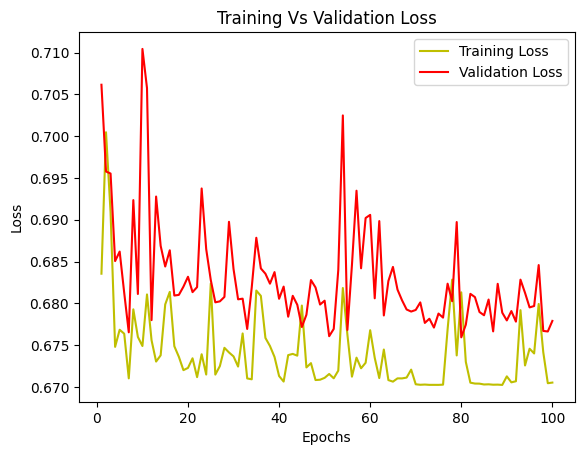

In [138]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#sepration of validation and training is not bigger and bigger

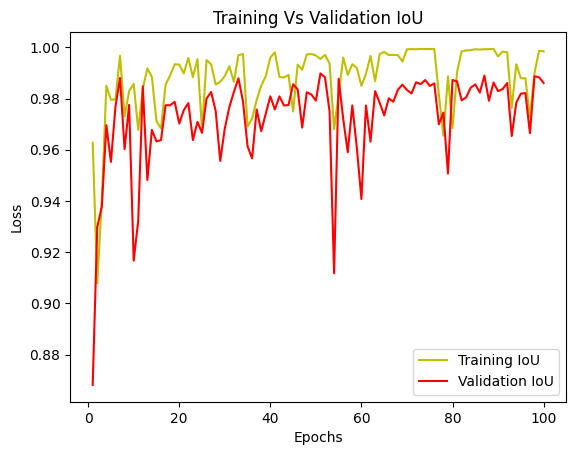

In [139]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#we need to check this validation IoU, it should be more
#we can reduce dropout while making model

In [140]:
model_history.params

{'verbose': 1, 'epochs': 100, 'steps': 105}

In [141]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1680, 128, 128, 3)
(720, 128, 128, 3)
(1680, 128, 128, 3)
(720, 128, 128, 3)


In [146]:
y_pred = model.predict(X_test) #predicting model
print(y_pred.shape)
print(len(y_pred))
print(y_pred)

23/23 [==============================] - 1s 41ms/step
(720, 128, 128, 3)
720
[[[[3.49880662e-03 1.34062924e-04 9.96367097e-01]
   [1.13085855e-03 4.79393520e-06 9.98864293e-01]
   [4.02049714e-04 1.63513187e-06 9.99596298e-01]
   ...
   [1.01669151e-02 4.03260783e-04 9.89429832e-01]
   [1.95052437e-02 1.55693735e-03 9.78937805e-01]
   [2.85753869e-02 9.25255753e-03 9.62172091e-01]]

  [[1.23759033e-03 1.40278416e-06 9.98761058e-01]
   [1.65365098e-04 3.03375236e-09 9.99834776e-01]
   [1.33631256e-04 5.05923392e-09 9.99866486e-01]
   ...
   [6.39577163e-03 1.36864192e-05 9.93590593e-01]
   [1.11763217e-02 8.49237476e-05 9.88738656e-01]
   [1.96029637e-02 1.07809505e-03 9.79318917e-01]]

  [[8.51207413e-04 1.38891130e-06 9.99147356e-01]
   [2.47985270e-04 1.93142058e-09 9.99752045e-01]
   [7.10986133e-05 6.36549036e-10 9.99928892e-01]
   ...
   [5.86978532e-03 9.11825737e-06 9.94121134e-01]
   [8.05093348e-03 4.43522586e-05 9.91904736e-01]
   [1.94878206e-02 7.45789555e-04 9.79766309e-01

In [143]:
y_pred_argmax = np.argmax(y_pred, axis=3)
print(len(y_pred_argmax))
print(y_pred_argmax)

720
[[[2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  ...
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  ...
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]
  [2 2 2 ... 2 2 2]]]


In [145]:
y_test_argmax = np.argmax(y_test, axis=3)
y_test_argmax

array([[[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

#Comparing prediction results


*   using test images using images and predicted result images



In [ ]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 35ms/step


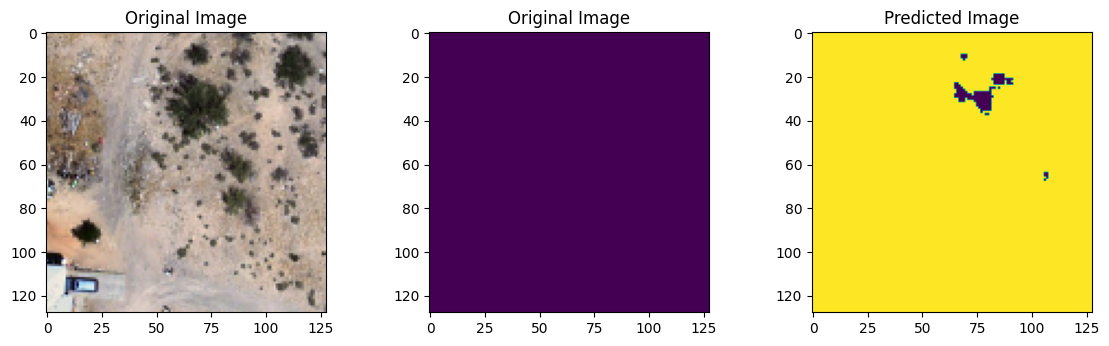

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)

#Model save and reload

In [ ]:
from keras.models import load_model

In [ ]:
model.save("satellite_segmentation_full.h5")

In [ ]:
saved_model = load_model('/content/satellite_segmentation_full.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

In [ ]:
#saved_model.get_config()

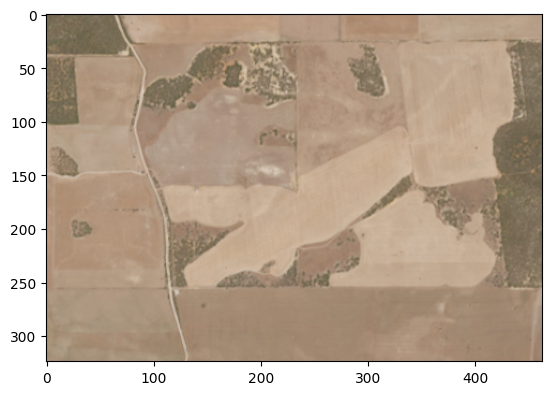

In [ ]:
img = os.path.join(base_input_folder, "image-1.tiff")
plt.imshow(Image.open(img))

In [ ]:
original_image = Image.open(img)
def create_patches(image, patch_size=128):
  width, height = image.size
  patches = []
  for i in range(0, height, patch_size):
      for j in range(0, width, patch_size):
          patch = image.crop((j, i, j+patch_size, i+patch_size))
          patch_array = np.array(patch)
          patches.append(patch_array)
  return np.array(patches)

# Create patches
patches = create_patches(original_image)

In [ ]:
patches.shape

(12, 128, 128, 3)

In [ ]:
prediction = saved_model.predict(patches)
#predicted_image = np.argmax(prediction, axis=3)
#predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 0s 186ms/step


In [ ]:
prediction

array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 1.8594281e-09, 9.9999994e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 3.5526260e-33, 9.9999994e-01],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.9999994e-01],
         [0.0000000e+00, 0.0000000e+00, 0.000

In [ ]:
# Get the class with highest probability for each pixel
predicted_classes = np.argmax(prediction, axis=3)

# Reconstruct the full image from patches
def reconstruct_from_patches(patches, original_size):
  height, width = original_size
  reconstructed = np.zeros((height, width), dtype=np.uint8)
  patch_size = patches.shape[1]
  index = 0
  for i in range(0, height - patch_size + 1, patch_size): # Adjust loop range to avoid going out of bounds
      for j in range(0, width - patch_size + 1, patch_size):
          reconstructed[i:i+patch_size, j:j+patch_size] = patches[index]
          index += 1
  return reconstructed

predicted_image = reconstruct_from_patches(predicted_classes, original_image.size)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

In [ ]:
# Create a custom colormap
colors = [color_mapping[i] for i in range(4)]  # Assuming 4 classes (0 to 3)
custom_cmap = mcolors.ListedColormap(colors)

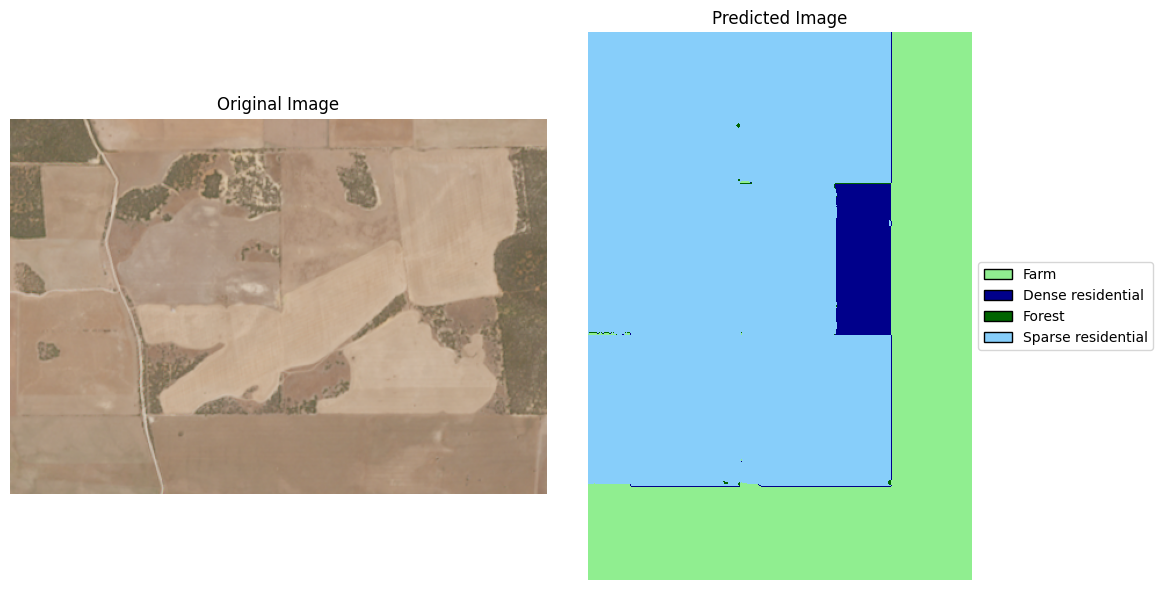

In [ ]:
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(121)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

# Predicted Image
plt.subplot(122)
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap=custom_cmap, vmin=0, vmax=3)  # You might want to use a different colormap
plt.axis('off')

# Create custom legend
legend_elements = [mpatches.Patch(facecolor=color_mapping[i], edgecolor='black',
                                label=list(label_mapping.keys())[i].capitalize())
                 for i in range(4)]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [ ]:
print(f"Original image size: {original_image.size}")
print(f"Original image size: {predicted_image.size}")



Original image size: (463, 324)
Original image size: 150012
